## Summary

In this project I checked how model from OpenAI performs on zero-shot classification of flowers task. 

Still flower species are quite widespread datasets, probably, they were present in the training data of the CLIP model. What if we need to train a classifier for more specific task, where CLIP model couldn't generalize well, as it cannot handle new classes or images beyond the domain they have been trained with. So in this notebook I wanted to check an idea to train a simple gradient boosting algorithm CatBoost on embedding vectors from CLIP model and see whether it will improve metrics.

### Results of validation
- CLIP zero-shot classification - $F_1 = 90\%$
- CatBoostClassifier trained on vector embeddings from CLIP model - $F_1 = 95.9\%$

### What is CLIP

CLIP (Contrastive Language-Image Pre-Training) is a neural network trained on a variety of (image, text) pairs. It can be instructed in natural language to predict the most relevant text snippet, given an image, without directly optimizing for the task, similarly to the zero-shot capabilities of GPT-2 and 3. We found CLIP matches the performance of the original ResNet50 on ImageNet “zero-shot” without using any of the original 1.28M labeled examples, overcoming several major challenges in computer vision.


In [1]:
pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to c:\users\sanke\appdata\local\temp\pip-req-build-f40zodz3
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git 'C:\Users\sanke\AppData\Local\Temp\pip-req-build-f40zodz3'


In [2]:
import clip
import torch
import clip
from PIL import Image
from glob import glob
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.manifold import TSNE

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [4]:
import os
path_file = r'C:\Users\sanke\OneDrive\Documents\Sem_3\Projects\CLIP_and_CatBoost\flowers\*/*'
files = glob(path_file)
print(files)
df = pd.DataFrame({
    'path': files,
    'category': [os.path.basename(os.path.dirname(x)) for x in files]
})


categories = df['category'].unique()
mapping = {x:i for (i,x) in enumerate(categories)}

print(df)
print(mapping)

['C:\\Users\\sanke\\OneDrive\\Documents\\Sem_3\\Projects\\CLIP_and_CatBoost\\flowers\\astilbe\\10091895024_a2ea04cda6_c.jpg', 'C:\\Users\\sanke\\OneDrive\\Documents\\Sem_3\\Projects\\CLIP_and_CatBoost\\flowers\\astilbe\\1033455028_f0c6518ec9_c.jpg', 'C:\\Users\\sanke\\OneDrive\\Documents\\Sem_3\\Projects\\CLIP_and_CatBoost\\flowers\\astilbe\\10373087134_927b53fb9f_c.jpg', 'C:\\Users\\sanke\\OneDrive\\Documents\\Sem_3\\Projects\\CLIP_and_CatBoost\\flowers\\astilbe\\1052212431_4963309d03_c.jpg', 'C:\\Users\\sanke\\OneDrive\\Documents\\Sem_3\\Projects\\CLIP_and_CatBoost\\flowers\\astilbe\\1052219251_d03970e956_c.jpg', 'C:\\Users\\sanke\\OneDrive\\Documents\\Sem_3\\Projects\\CLIP_and_CatBoost\\flowers\\astilbe\\1052586928_366c5255b8_c.jpg', 'C:\\Users\\sanke\\OneDrive\\Documents\\Sem_3\\Projects\\CLIP_and_CatBoost\\flowers\\astilbe\\1052587144_34c9f0714c_c.jpg', 'C:\\Users\\sanke\\OneDrive\\Documents\\Sem_3\\Projects\\CLIP_and_CatBoost\\flowers\\astilbe\\1053073526_188a5b816e_c.jpg', 'C:\\

### Dataset

Dataset consists of 16 flower species, all classes are almost balanced

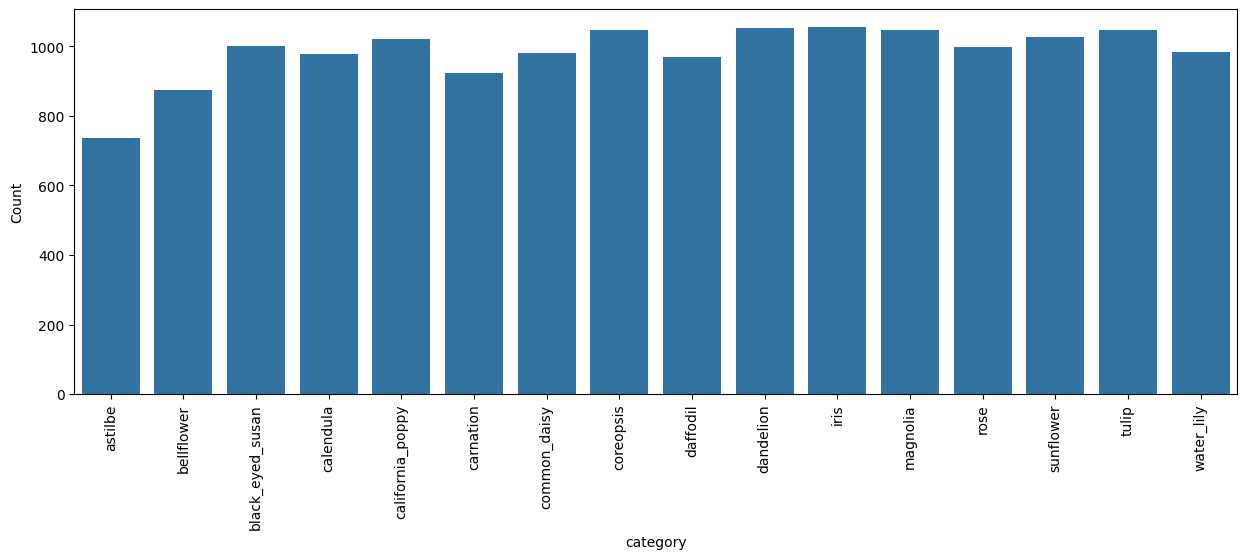

In [5]:
plt.figure(figsize=(15,5))
sns.barplot(df.groupby('category').count().reset_index(), y='path', x='category')
plt.ylabel('Count')
plt.xticks(rotation=90);

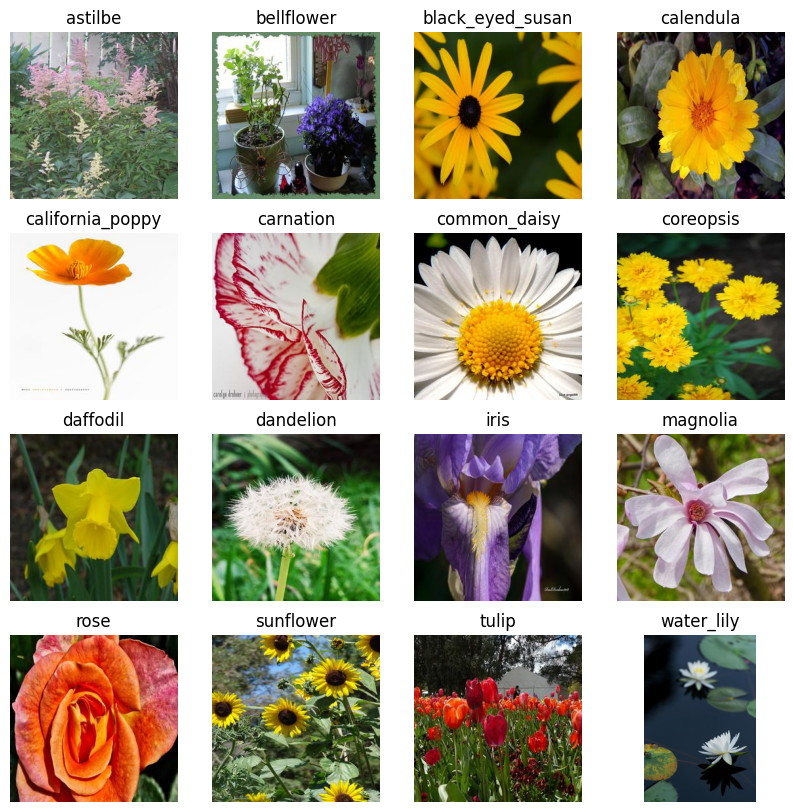

In [6]:
plt.figure(figsize=(10,10))
nrows = 4
ncols = 4
for i, row in df.groupby('category').sample(1, random_state=1).reset_index(drop=True).iterrows():
    plt.subplot(nrows, ncols, i + 1)
    img = np.array(Image.open(row['path']))
    plt.axis('off')
    plt.imshow(img)
    plt.title(row['category'])

## 1. Zero-shot classification using CLIP

What makes CLIP model zero-classification possible? Image and text encoder creates a 512-dimensional vector embeddings that map to the same vector space. So for this task we can write dataset classes as text sentences, in our case:

**classes** = \[`astilbe`,
 `daffodil`,
 `black_eyed_susan`,
 `bellflower`,
 `common_daisy`,
 `coreopsis`,
 `dandelion`,
 `water_lily`,
 `carnation`,
 `calendula`,
 `california_poppy`,
 `sunflower`,
 `tulip`,
 `rose`,
 `magnolia`,
 `iris`\]
 
Imagine a small example from the scheme below, where we have 3 classes (`Black-Eyed Susan`, `Bellflower`, `Dandelion`). 

First we encode this three text classes to vector embeddings:


$$\text{"Bellflower"}\rightarrow T_1$$

$$\text{"Dandelion"}\rightarrow T_2$$

$$\text{"Black-Eyed Susan"}\rightarrow T_3$$

Given an photo of a Black-Eyed Susan, we encode it with the ViT model to create vector $I_1$. When we calculate the similarity of these vectors with cosine similarity, we expect $sim(T_3,I_1)$ to return the highest score.


In [6]:
preds = []
text = clip.tokenize(categories).to(device)
for i, row in tqdm(df.iterrows(), total=len(df)):
    image = preprocess(Image.open(row['path'])).unsqueeze(0).to(device)
    with torch.no_grad():
        image_features = model.encode_image(image)
        text_features = model.encode_text(text)
        logits_per_image, logits_per_text = model(image, text)
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()
    preds.append(np.argmax(probs))

100%|██████████| 15740/15740 [17:58<00:00, 14.60it/s]


Zero-shot classification gives $F_1 = 90\%$

In [7]:
print(f"F1 = {f1_score(df['category'].map(mapping), preds, average='micro'):.3f}")

F1 = 0.900


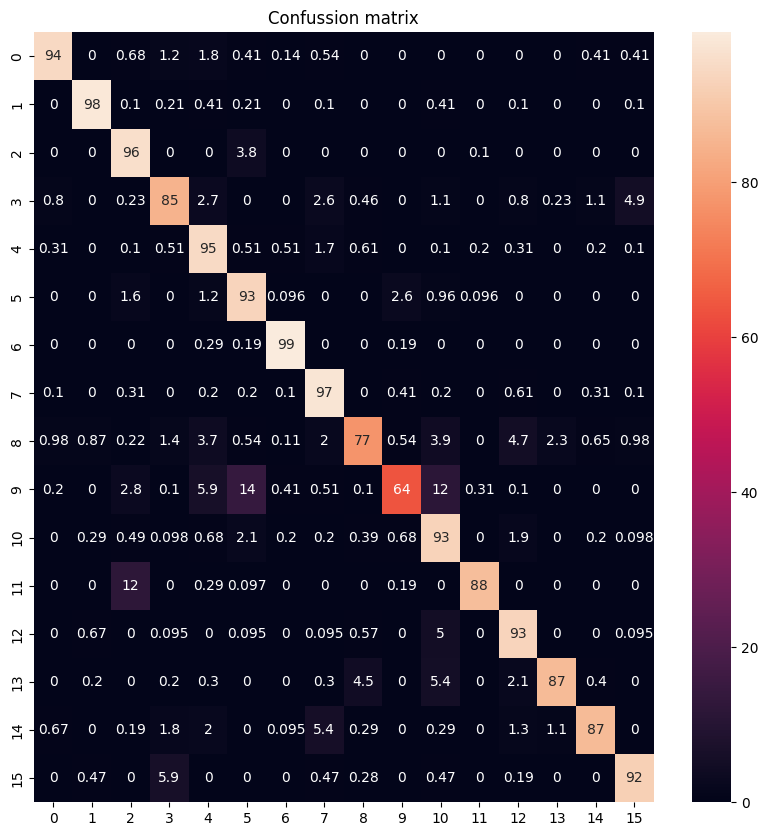

In [8]:
plt.figure(figsize=(10,10))
cm = confusion_matrix(df['category'].map(mapping), preds)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm, annot=True) 
plt.title('Confussion matrix')
plt.show()

## 2. CatBoost trained on vector embeddings from CLIP model

The idea behind this experiment is to train gradient boosting algorithm on vector embeddings from CLIP model. We encode every flower image using CLIP image encoder and then train CatBoost algorithm on this vectors. In vector space flowers with the same species should lie close one to another in vector space, so gradient boosting algorithm, probably, should catch this dependencies.

First let's calculate vector embeddings for every flower image.

In [9]:
embeddings = []
for i, row in tqdm(df.iterrows(), total=len(df)):
    image = preprocess(Image.open(row['path'])).unsqueeze(0).to(device)
    with torch.no_grad():
        image_features = model.encode_image(image).cpu().numpy().flatten()
        embeddings.append(image_features)

100%|██████████| 15740/15740 [03:16<00:00, 80.01it/s]


To show that vector embeddings form clusters, let's visualize this vectors using tsne algorithm.

In [10]:
tsne = TSNE(n_components=2, learning_rate=150, perplexity=30, angle=0.2, verbose=2, random_state=42).fit_transform(np.array(embeddings))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 15740 samples in 0.004s...
[t-SNE] Computed neighbors for 15740 samples in 3.379s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15740
[t-SNE] Computed conditional probabilities for sample 2000 / 15740
[t-SNE] Computed conditional probabilities for sample 3000 / 15740
[t-SNE] Computed conditional probabilities for sample 4000 / 15740
[t-SNE] Computed conditional probabilities for sample 5000 / 15740
[t-SNE] Computed conditional probabilities for sample 6000 / 15740
[t-SNE] Computed conditional probabilities for sample 7000 / 15740
[t-SNE] Computed conditional probabilities for sample 8000 / 15740
[t-SNE] Computed conditional probabilities for sample 9000 / 15740
[t-SNE] Computed conditional probabilities for sample 10000 / 15740
[t-SNE] Computed conditional probabilities for sample 11000 / 15740
[t-SNE] Computed conditional probabilities for sample 12000 / 15740
[t-SNE] Computed conditional probabilities for sam

In [11]:
import plotly.express as px


fig = px.scatter(x=tsne.T[0], y=tsne.T[1], color = df['category'].map(mapping).to_numpy(), width=800, height=800)
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.update_layout(
    plot_bgcolor='white'
)
fig.show()

Now let's train CatBoost model.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(embeddings, df['category'].map(mapping).to_numpy(), test_size=0.2, random_state=42)

model = CatBoostClassifier(iterations=1000,
                           task_type="GPU",
                           devices='0:1')
model.fit(X_train,
          y_train,
          verbose=False)
y_pred = model.predict(X_test)

Training CatBoostClassifier on embedding vectors gives $F_1 = 95.9\%$

In [13]:
print(f"F1 = {f1_score(y_test, y_pred, average='micro'):.3f}")

F1 = 0.958


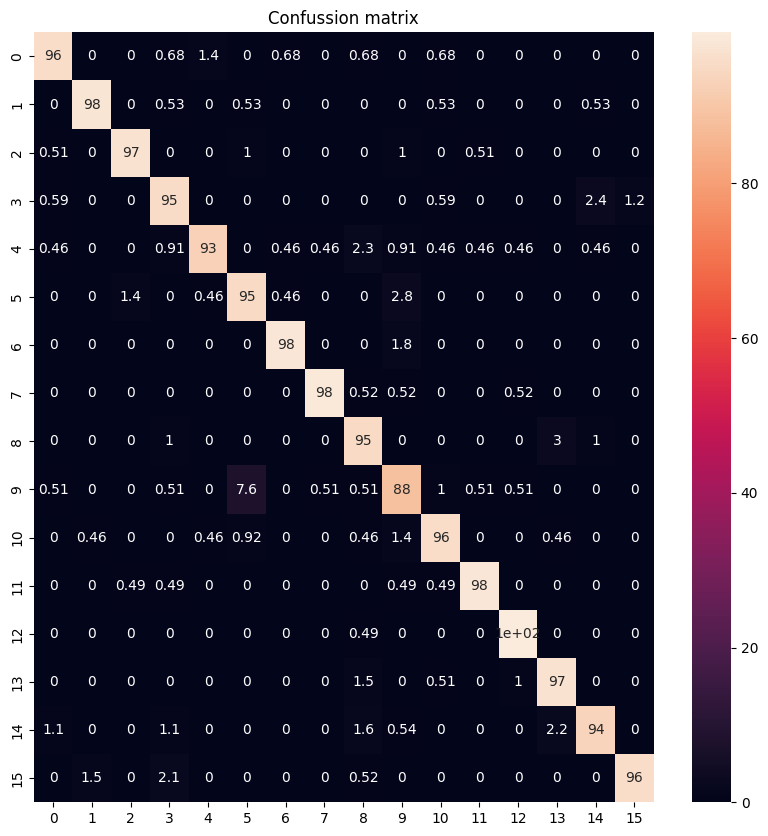

In [14]:
plt.figure(figsize=(10,10))
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm, annot=True) 
plt.title('Confussion matrix')
plt.show()